# Discriminative vs. Generative Modeling for Cardiovascular Risk Prediction 


### adding libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading dataset


In [2]:
# Step 1: Load the dataset
df = pd.read_csv("data/heart_disease_uci.csv")  # replace with your actual file path if needed

In [3]:
df

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,917,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,919,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


# Task 1: Data Exploration & Gaussian Fitting

### • Handle missing or invalid values via deletion or imputation. 


In [4]:
# Step 2: Drop irrelevant columns
# df.drop(columns=["id", "dataset"], inplace=True)

# Step 3: Binarize target column
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
# df.drop(columns=["num"], inplace=True)

# Step 4: Drop rows with any missing values
df.dropna(inplace=True)

# Step 5: Check remaining shape and confirm no missing values
print("Data shape after dropping missing values:", df.shape)
print("Remaining missing values:\n", df.isnull().sum())

Data shape after dropping missing values: (299, 17)
Remaining missing values:
 id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
target      0
dtype: int64


### • Plot distributions (histogram or KDE) of all features per class. 


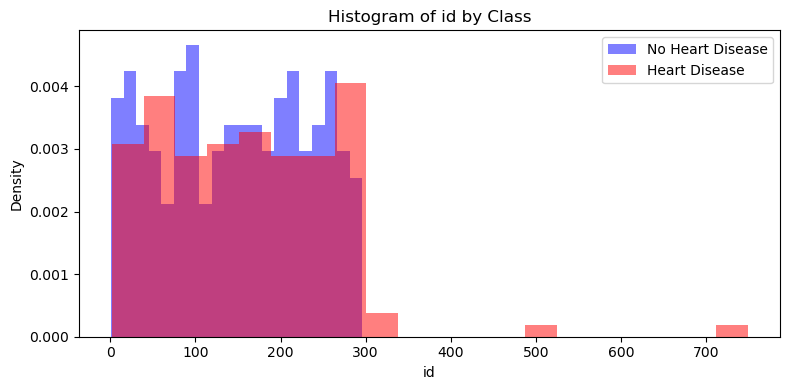

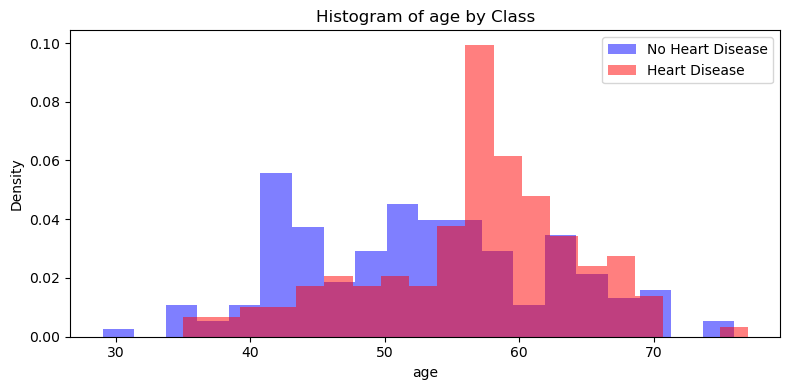

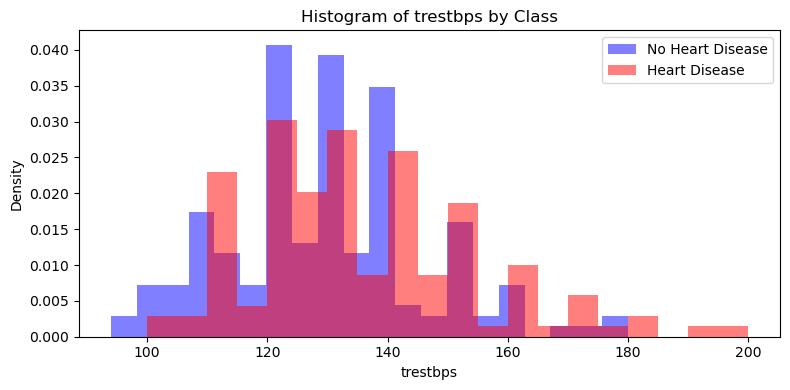

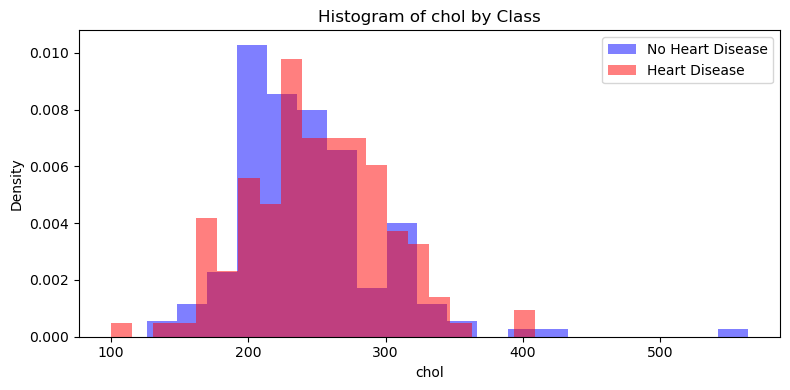

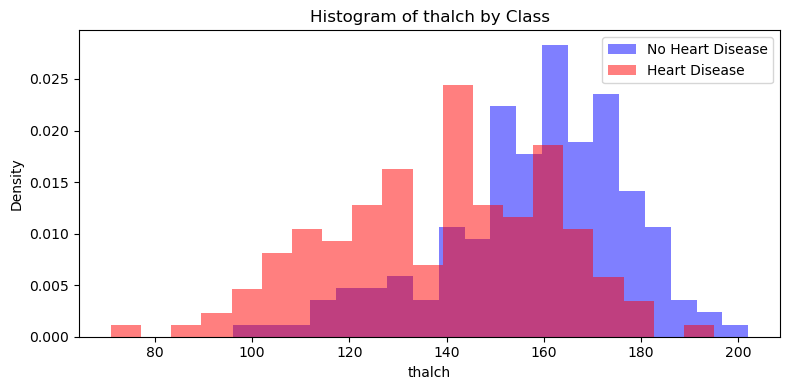

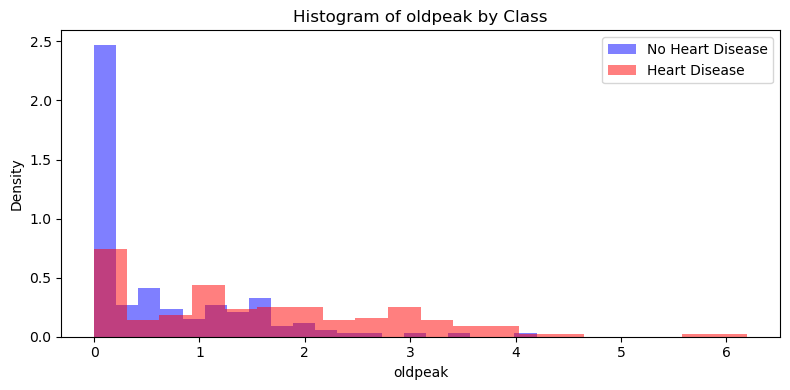

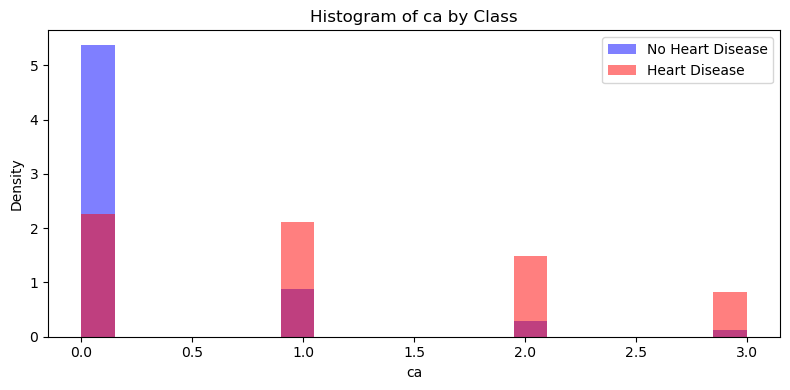

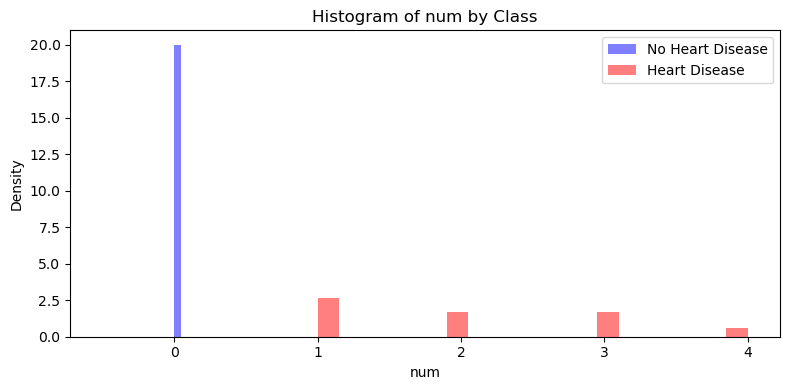

In [5]:
# Get list of numeric columns (excluding target)
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.drop("target")

# Plot histogram for each numeric column, separated by class
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(df[df["target"] == 0][col], bins=20, alpha=0.5, label="No Heart Disease", color="blue", density=True)
    plt.hist(df[df["target"] == 1][col], bins=20, alpha=0.5, label="Heart Disease", color="red", density=True)
    plt.title(f"Histogram of {col} by Class")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


### • Select two informative features (e.g., chol and thalach). 


In [6]:
# Select the two features: 'chol' and 'thalch'
selected_features = ["chol", "thalch", "target"]

# Extract subset
df_selected = df[selected_features]

# Display first few rows
print(df_selected.head())

    chol  thalch  target
0  233.0   150.0       0
1  286.0   108.0       1
2  229.0   129.0       1
3  250.0   187.0       0
4  204.0   172.0       0


### Fit 2D Gaussian distributions (one per class) and plot contour maps.

C:\Users\prca\AppData\Local\Temp\ipykernel_19288\802404007.py:33: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z0, levels=5, colors='blue', linestyles='dashed', label="No Heart Disease")
C:\Users\prca\AppData\Local\Temp\ipykernel_19288\802404007.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z1, levels=5, colors='red', linestyles='solid', label="Heart Disease")


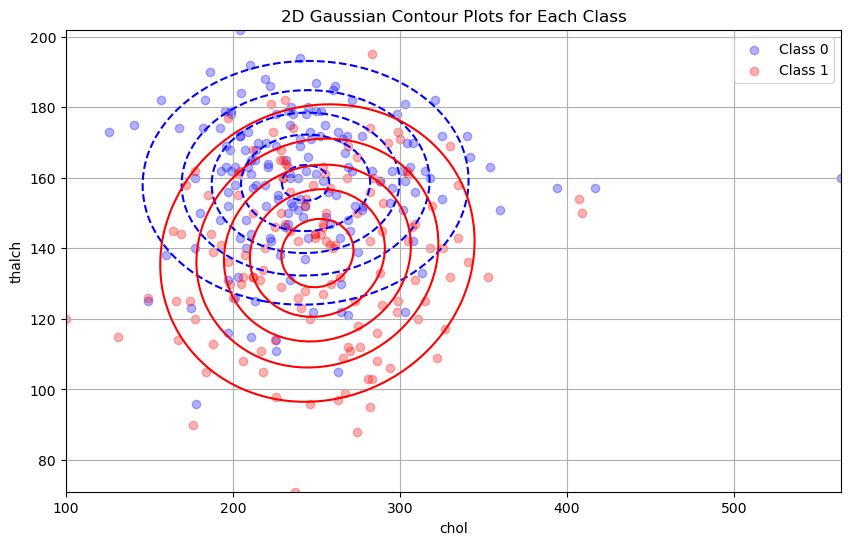

In [7]:
# Step 1: Extract data by class
X0 = df_selected[df_selected["target"] == 0][["chol", "thalch"]].values
X1 = df_selected[df_selected["target"] == 1][["chol", "thalch"]].values

# Step 2: Compute means and covariances
mu0 = np.mean(X0, axis=0)
mu1 = np.mean(X1, axis=0)
cov0 = np.cov(X0, rowvar=False)
cov1 = np.cov(X1, rowvar=False)

# Step 3: Create a mesh grid
x = np.linspace(df_selected["chol"].min(), df_selected["chol"].max(), 100)
y = np.linspace(df_selected["thalch"].min(), df_selected["thalch"].max(), 100)
X, Y = np.meshgrid(x, y)
grid = np.stack([X.ravel(), Y.ravel()], axis=1)

# Step 4: Multivariate Gaussian PDF function
def gaussian_pdf(x, mean, cov):
    d = mean.shape[0]
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm_const = 1.0 / (np.power((2*np.pi), d/2) * np.sqrt(det))
    diff = x - mean
    result = norm_const * np.exp(-0.5 * np.sum(diff @ inv * diff, axis=1))
    return result

# Step 5: Evaluate PDF on grid
Z0 = gaussian_pdf(grid, mu0, cov0).reshape(X.shape)
Z1 = gaussian_pdf(grid, mu1, cov1).reshape(X.shape)

# Step 6: Plot
plt.figure(figsize=(10, 6))
plt.contour(X, Y, Z0, levels=5, colors='blue', linestyles='dashed', label="No Heart Disease")
plt.contour(X, Y, Z1, levels=5, colors='red', linestyles='solid', label="Heart Disease")
plt.scatter(X0[:, 0], X0[:, 1], color='blue', alpha=0.3, label="Class 0")
plt.scatter(X1[:, 0], X1[:, 1], color='red', alpha=0.3, label="Class 1")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.title("2D Gaussian Contour Plots for Each Class")
plt.legend()
plt.grid(True)
plt.show()


### • Evaluate Gaussian assumption via plots and normality tests. 



📊 Evaluating Normality for: chol | Class 0


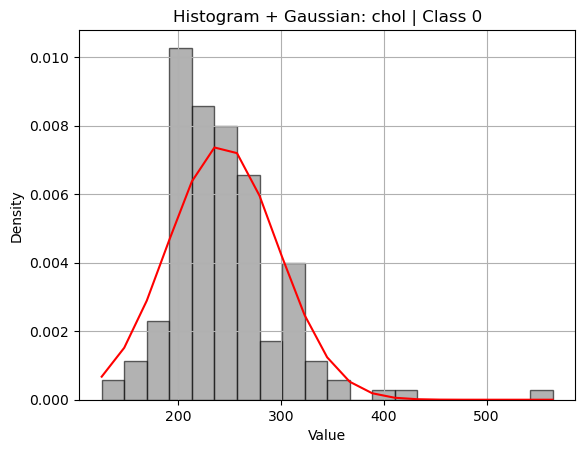

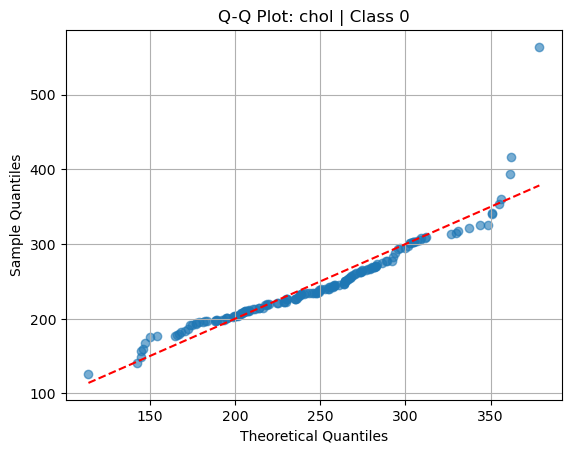


📊 Evaluating Normality for: chol | Class 1


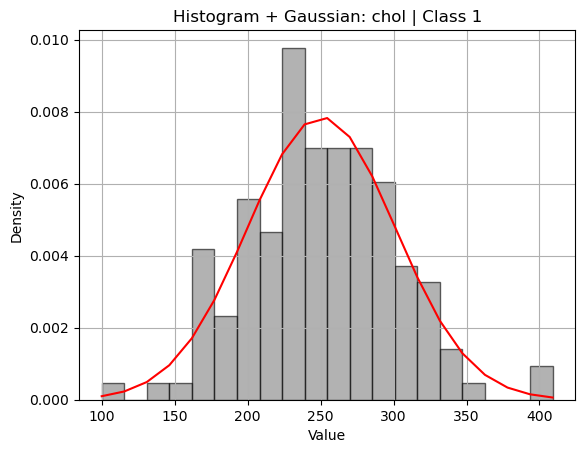

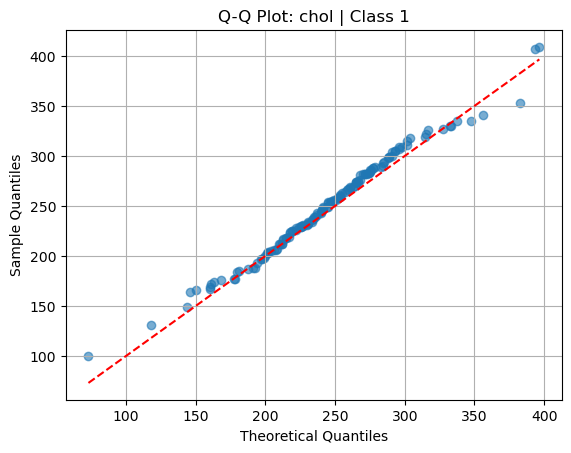


📊 Evaluating Normality for: thalch | Class 0


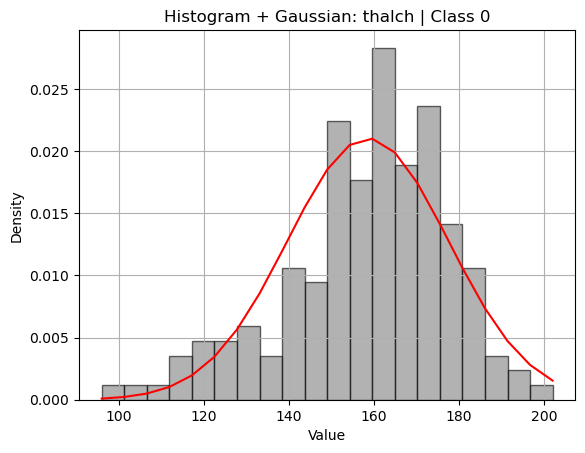

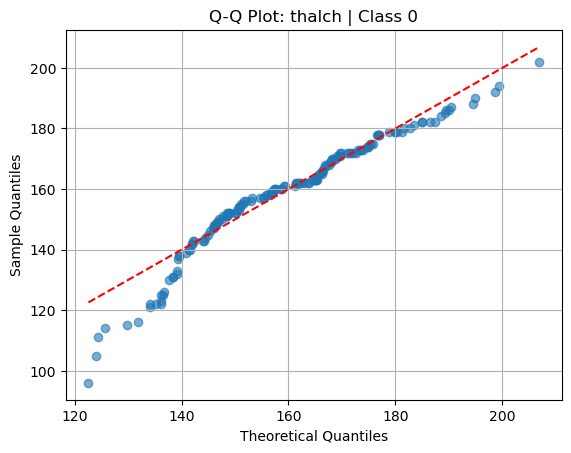


📊 Evaluating Normality for: thalch | Class 1


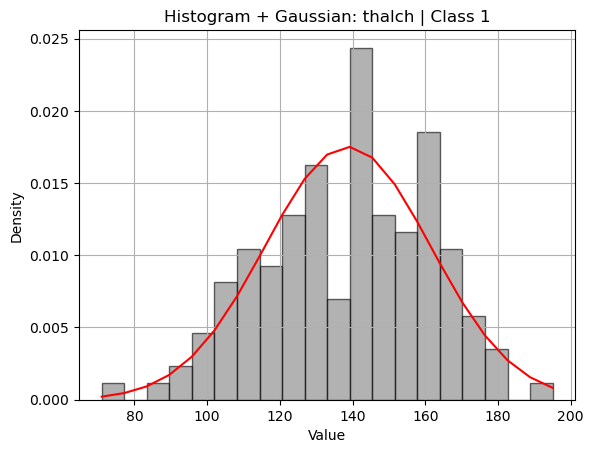

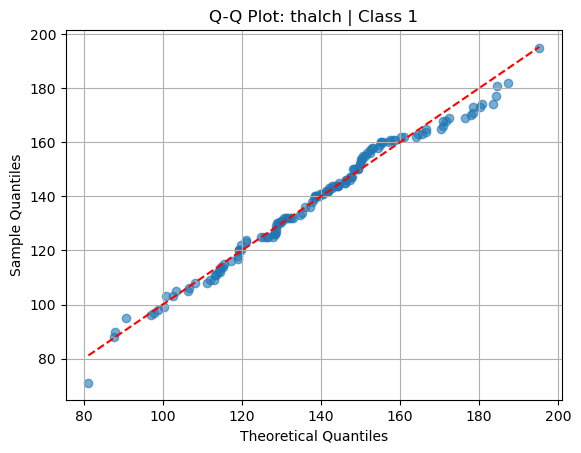

In [10]:

# Helper: Plot histograms with normal curve
def plot_hist_with_gaussian(data, title):
    mu = np.mean(data)
    sigma = np.std(data)

    count, bins, _ = plt.hist(data, bins=20, density=True, alpha=0.6, color='gray', edgecolor='black')
    gauss_curve = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(bins - mu)**2 / (2*sigma**2))
    plt.plot(bins, gauss_curve, color='red')
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

# Helper: Manual Q-Q plot
def qq_plot(data, title):
    sorted_data = np.sort(data)
    n = len(data)
    theoretical_q = np.sort(np.random.normal(np.mean(data), np.std(data), n))
    
    plt.scatter(theoretical_q, sorted_data, alpha=0.6)
    plt.plot(theoretical_q, theoretical_q, color='red', linestyle='--')
    plt.title("Q-Q Plot: " + title)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

# Analyze for each feature per class
for col in ["chol", "thalch"]:
    for label in [0, 1]:
        data = df_selected[df_selected["target"] == label][col].values
        title = f"{col} | Class {label}"

        print(f"\n📊 Evaluating Normality for: {title}")
        plot_hist_with_gaussian(data, f"Histogram + Gaussian: {title}")
        qq_plot(data, title)


# Task 2: Generative Modeling (Gaussian Classifier)

### • Estimate mean and covariance matrix for each class. 

In [9]:
# Extract feature matrix and labels
X = df_selected[["chol", "thalch"]].values
y = df_selected["target"].values

# Split by class
X0 = X[y == 0]
X1 = X[y == 1]

# Mean vectors
mu0 = np.mean(X0, axis=0)
mu1 = np.mean(X1, axis=0)

# Covariance matrices
cov0 = np.cov(X0, rowvar=False)
cov1 = np.cov(X1, rowvar=False)

# Display results
print("Class 0 (No Heart Disease):")
print("Mean vector:\n", mu0)
print("Covariance matrix:\n", cov0)

print("\nClass 1 (Heart Disease):")
print("Mean vector:\n", mu1)
print("Covariance matrix:\n", cov1)


Class 0 (No Heart Disease):
Mean vector:
 [243.49375 158.58125]
Covariance matrix:
 [[2889.87417453   19.5351022 ]
 [  19.5351022   362.64744497]]

Class 1 (Heart Disease):
Mean vector:
 [250.57553957 138.67625899]
Covariance matrix:
 [[2602.62287561   92.53550203]
 [  92.53550203  523.00312793]]


### • Derive and plot decision boundary (log-likelihood ratio). 


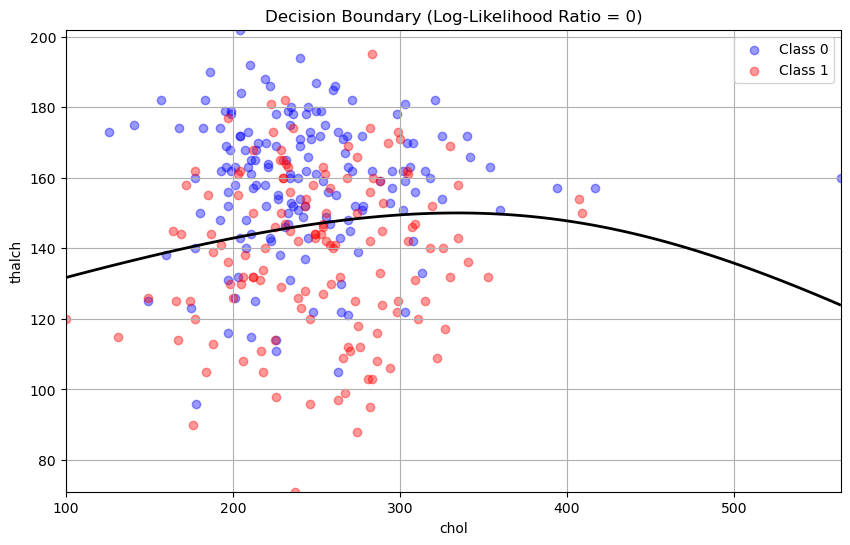

In [10]:
# Reuse mu0, mu1, cov0, cov1 from previous step
def multivariate_gaussian(x, mean, cov):
    size = mean.shape[0]
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm_const = 1.0 / (np.power((2 * np.pi), size / 2) * np.sqrt(det))
    diff = x - mean
    exponent = -0.5 * np.sum(diff @ inv * diff, axis=1)
    return norm_const * np.exp(exponent)

# Mesh grid
x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
y_vals = np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
X_grid, Y_grid = np.meshgrid(x_vals, y_vals)
grid_points = np.c_[X_grid.ravel(), Y_grid.ravel()]

# Evaluate densities
p0 = multivariate_gaussian(grid_points, mu0, cov0)
p1 = multivariate_gaussian(grid_points, mu1, cov1)

# Log-likelihood ratio
log_ratio = np.log(p1 + 1e-12) - np.log(p0 + 1e-12)  # add epsilon to avoid log(0)
log_ratio = log_ratio.reshape(X_grid.shape)

# Plot
plt.figure(figsize=(10, 6))
plt.contour(X_grid, Y_grid, log_ratio, levels=[0], colors='black', linewidths=2)
plt.scatter(X0[:, 0], X0[:, 1], color='blue', alpha=0.4, label="Class 0")
plt.scatter(X1[:, 0], X1[:, 1], color='red', alpha=0.4, label="Class 1")
plt.title("Decision Boundary (Log-Likelihood Ratio = 0)")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.legend()
plt.grid(True)
plt.show()


### Compare: 
o LDA (shared covariance) 

o QDA (distinct covariance) 

This plot will show:

Red dashed curve → QDA (curved boundary)

Blue solid line → LDA (linear boundary)

C:\Users\prca\AppData\Local\Temp\ipykernel_19288\2027179367.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, log_ratio, levels=[0], colors='red', linewidths=2, linestyles='--', label='QDA')
C:\Users\prca\AppData\Local\Temp\ipykernel_19288\2027179367.py:19: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, log_ratio_lda, levels=[0], colors='blue', linewidths=2, linestyles='-', label='LDA')


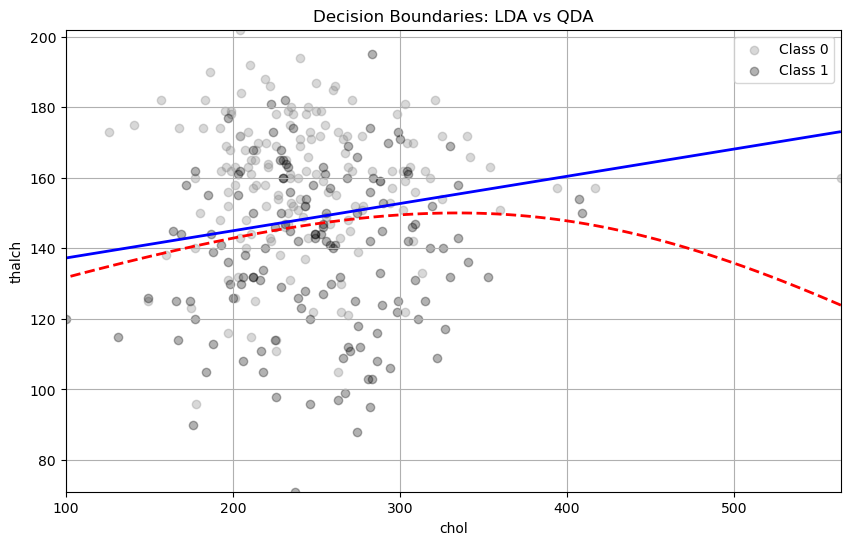

In [11]:
# Step 1: Shared covariance for LDA
shared_cov = (cov0 + cov1) / 2

# Step 2: Evaluate Gaussian with shared covariance for LDA
p0_lda = multivariate_gaussian(grid_points, mu0, shared_cov)
p1_lda = multivariate_gaussian(grid_points, mu1, shared_cov)
log_ratio_lda = np.log(p1_lda + 1e-12) - np.log(p0_lda + 1e-12)
log_ratio_lda = log_ratio_lda.reshape(X_grid.shape)

# Step 3: QDA was already done earlier (log_ratio)

# Step 4: Plot both boundaries
plt.figure(figsize=(10, 6))

# QDA
plt.contour(X_grid, Y_grid, log_ratio, levels=[0], colors='red', linewidths=2, linestyles='--', label='QDA')

# LDA
plt.contour(X_grid, Y_grid, log_ratio_lda, levels=[0], colors='blue', linewidths=2, linestyles='-', label='LDA')

# Data points
plt.scatter(X0[:, 0], X0[:, 1], color='gray', alpha=0.3, label="Class 0")
plt.scatter(X1[:, 0], X1[:, 1], color='black', alpha=0.3, label="Class 1")

# Labels
plt.title("Decision Boundaries: LDA vs QDA")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.legend()
plt.grid(True)
plt.show()


###  Discuss impact of covariance assumption.

Discussion: Impact of Covariance Assumption (LDA vs QDA)
What is the assumption?
LDA assumes all classes share the same covariance matrix.

QDA allows each class to have its own covariance matrix.

---

Impact on Modeling
| Aspect                | LDA (Shared Covariance)                  | QDA (Distinct Covariance)      |
| --------------------- | ---------------------------------------- | ------------------------------ |
| **Decision Boundary** | Linear (straight line)                   | Quadratic (curved)             |
| **Model Complexity**  | Lower                                    | Higher                         |
| **Overfitting Risk**  | Lower (good for small data)              | Higher (needs more data)       |
| **Speed**             | Faster (fewer parameters)                | Slower (more matrix inversion) |
| **Assumption**        | Features behave similarly across classes | Features can vary per class    |

---

When LDA Works Better

When class distributions are similar in shape/scale.

When you have limited data — more robust.

---

When QDA Works Better

When class distributions are clearly different (e.g., one class more spread out).

When you have enough data to reliably estimate covariance for each class.

---

In Your Plot:

If QDA's boundary curves and better separates classes, that suggests class-specific variability matters.

If both LDA and QDA give similar lines, then shared covariance (LDA) might be a safe and efficient choice.

### based on our plot
Analysis of Your Plot: LDA vs QDA

Blue Line = LDA (Linear Discriminant Analysis)

Red Dashed Curve = QDA (Quadratic Discriminant Analysis)

Gray Dots = Data points (Class 0 and 1)

---

Observations:

Shape of boundary:

LDA is a straight line (as expected).

QDA is curved and seems to adapt more flexibly to the data spread.

Data distribution:

The data isn’t perfectly separable with a straight line.

Class 1 (probably higher risk) is more spread out in thalch, and Class 0 is tighter.

Boundary alignment:

The QDA boundary curves away at high cholesterol values — suggesting the model is adapting to class-specific variance in that region.

LDA assumes uniform variance in all directions, which seems to oversimplify things here.

---

Which is better here?

QDA likely performs better in this case because:

The classes show different variances — QDA models that.

The decision boundary of QDA bends in areas where LDA can't adapt.

From the plot, QDA better separates the lower region (right side), where LDA crosses dense class 1 points.

---

Conclusion:

If you have enough data, QDA is preferred here.

If you're worried about overfitting or limited data, LDA is still safer.


### Task 3: Gaussian Naive Bayes 
• Implement from scratch assuming conditional independence.

In [12]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = np.mean(X_c, axis=0)
            self.var[c] = np.var(X_c, axis=0) + 1e-6  # small value to avoid div-by-zero
            self.priors[c] = X_c.shape[0] / X.shape[0]

    def _gaussian_logpdf(self, x, mean, var):
        return -0.5 * np.sum(np.log(2 * np.pi * var) + ((x - mean) ** 2) / var, axis=1)

    def predict(self, X):
        log_probs = []
        for c in self.classes:
            prior = np.log(self.priors[c])
            class_cond = self._gaussian_logpdf(X, self.mean[c], self.var[c])
            log_probs.append(prior + class_cond)
        return np.argmax(log_probs, axis=0)

In [13]:
# Prepare data
X_gnb = df_selected[["chol", "thalch"]].values
y_gnb = df_selected["target"].values

# Train model
gnb = GaussianNaiveBayes()
gnb.fit(X_gnb, y_gnb)

# Predict (on training data for now)
y_pred = gnb.predict(X_gnb)

# Accuracy
accuracy = np.mean(y_pred == y_gnb)
print(f"Training accuracy: {accuracy:.3f}")


Training accuracy: 0.709


### • Estimate per-feature mean/variance per class. 


In [15]:

# Get features and labels
X = df_selected[["chol", "thalch"]].values
y = df_selected["target"].values
classes = np.unique(y)

# Initialize containers
means = {}
variances = {}

# Loop over classes
for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    variances[c] = np.var(X_c, axis=0)

    print(f"\nClass {c}:")
    print("Mean:", means[c])
    print("Variance:", variances[c])



Class 0:
Mean: [243.49375 158.58125]
Variance: [2871.81246094  360.38089844]

Class 1:
Mean: [250.57553957 138.67625899]
Variance: [2583.89897003  519.2405155 ]


### • Compute posterior probabilities. 


In [16]:
# Log-Gaussian PDF
def log_gaussian_pdf(x, mean, var):
    return -0.5 * (np.log(2 * np.pi * var) + ((x - mean) ** 2) / var)

# Compute log-posteriors for all samples
log_posteriors = np.zeros((X.shape[0], len(classes)))

for idx, c in enumerate(classes):
    mean = means[c]
    var = variances[c]
    prior = np.log(np.sum(y == c) / len(y))  # log prior
    log_likelihood = log_gaussian_pdf(X, mean, var).sum(axis=1)  # sum over features
    log_posteriors[:, idx] = prior + log_likelihood

# Convert to probabilities (optional)
posteriors = np.exp(log_posteriors)
posteriors /= np.sum(posteriors, axis=1, keepdims=True)  # normalize

# Preview
print("Posterior probabilities for first 5 samples:")
print(posteriors[:5])


Posterior probabilities for first 5 samples:
[[0.58234111 0.41765889]
 [0.07982231 0.92017769]
 [0.31004299 0.68995701]
 [0.80080159 0.19919841]
 [0.77524823 0.22475177]]


### • Compare decision boundaries with Task 2. 


| Model                    | Covariance assumption              | Decision boundary shape                           |
| ------------------------ | ---------------------------------- | ------------------------------------------------- |
| **QDA (Task 2)**         | Full covariance matrix per class   | Curved / Flexible                                 |
| **Naive Bayes (Task 3)** | Diagonal covariance (independence) | Still curved but **axis-aligned** (less flexible) |


QDA -> red
Naive Bayes -> green

C:\Users\prca\AppData\Local\Temp\ipykernel_19288\1061839665.py:21: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, log_ratio, levels=[0], colors='red', linewidths=2, linestyles='--', label="QDA")
C:\Users\prca\AppData\Local\Temp\ipykernel_19288\1061839665.py:24: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, log_ratio_gnb, levels=[0], colors='green', linewidths=2, linestyles='-', label="Naive Bayes")


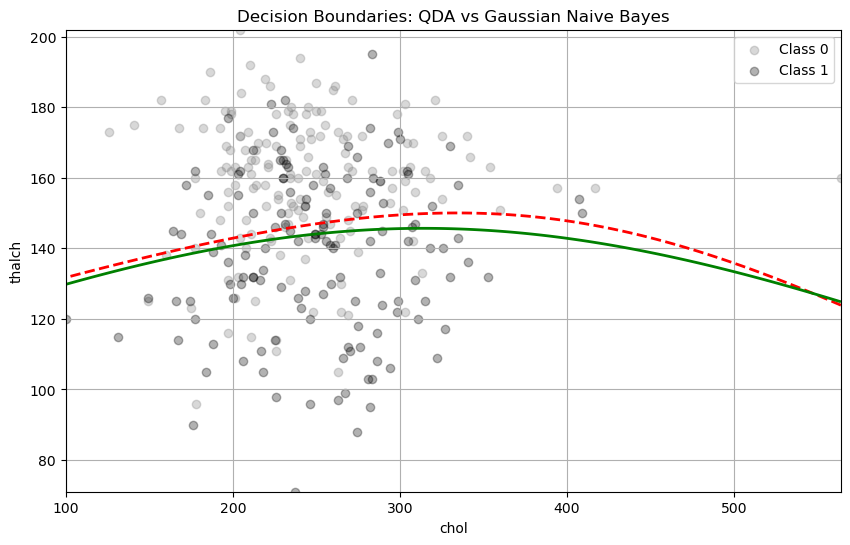

In [17]:
# Gaussian Naive Bayes log-posterior on the grid
def gnb_log_posteriors_grid(grid):
    log_post = np.zeros((grid.shape[0], len(classes)))
    for idx, c in enumerate(classes):
        mean = means[c]
        var = variances[c]
        prior = np.log(np.sum(y == c) / len(y))
        log_likelihood = log_gaussian_pdf(grid, mean, var).sum(axis=1)
        log_post[:, idx] = prior + log_likelihood
    return log_post

# Evaluate on grid
log_post_grid = gnb_log_posteriors_grid(grid_points)
log_ratio_gnb = log_post_grid[:, 1] - log_post_grid[:, 0]
log_ratio_gnb = log_ratio_gnb.reshape(X_grid.shape)

# Plot
plt.figure(figsize=(10, 6))

# QDA decision boundary (from earlier)
plt.contour(X_grid, Y_grid, log_ratio, levels=[0], colors='red', linewidths=2, linestyles='--', label="QDA")

# GNB decision boundary
plt.contour(X_grid, Y_grid, log_ratio_gnb, levels=[0], colors='green', linewidths=2, linestyles='-', label="Naive Bayes")

# Data points
plt.scatter(X0[:, 0], X0[:, 1], color='gray', alpha=0.3, label="Class 0")
plt.scatter(X1[:, 0], X1[:, 1], color='black', alpha=0.3, label="Class 1")

# Labels
plt.title("Decision Boundaries: QDA vs Gaussian Naive Bayes")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.legend()
plt.grid(True)
plt.show()


### • Discuss impact of correlation. 
